In [1]:
# Download stuff
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz
!tar xf spark-3.1.2-bin-hadoop3.2.tgz
!pip install -q findspark

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop3.2"

In [24]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
from datetime import datetime, date, timedelta
from dateutil import relativedelta
from pyspark.sql import SQLContext, Row
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql import DataFrame
from pyspark.sql.functions import *
from pyspark.sql.functions import to_timestamp, to_date
from pyspark.sql import functions as F  
from pyspark.sql.functions import collect_list, collect_set, concat, first, array_distinct, col, size, expr
from pyspark.sql import DataFrame 
import random
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
SparkContext.version



In [5]:
# Spark setup
spark = SparkSession.builder \
        .master('local[*]') \
        .appName('Venmo') \
        .config('spark.executor.memory', '10gb') \
        .config("spark.cores.max", "8") \
        .config("spark.executor.cores", "6") \
        .getOrCreate()

spark.sparkContext.getConf().getAll()

[('spark.app.id', 'local-1652506609828'),
 ('spark.driver.port', '36171'),
 ('spark.executor.id', 'driver'),
 ('spark.sql.warehouse.dir', 'file:/content/spark-warehouse'),
 ('spark.driver.host', '90c88447b531'),
 ('spark.executor.cores', '6'),
 ('spark.app.startTime', '1652506608357'),
 ('spark.executor.memory', '10gb'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.cores.max', '8'),
 ('spark.master', 'local[*]'),
 ('spark.submit.pyFiles', ''),
 ('spark.submit.deployMode', 'client'),
 ('spark.app.name', 'Venmo'),
 ('spark.ui.showConsoleProgress', 'true')]

In [6]:
data1 = spark.read.parquet('VenmoSample.snappy.parquet')
data_dict = pd.read_csv('Venmo_Emoji_Classification_Dictionary.csv')
data_dict_text = pd.read_csv('Venmo Word Classification Dictonary Dict.csv')
# Words Added: 
# 1. surf - activity
# 2. sun - travel
# 3. sea - travel
# 4. ocean - travel
# 5. mail - transportation
# 6. marvel - activity
# 7. avengers - activity
# 8. dividend - cash
# 9. crypto - cash
# 10. greece - travel

In [7]:
# data1.schema
data1.createOrReplaceTempView("data1")
data1.show(5)

+-------+-------+----------------+-------------------+------------+-----------+--------------------+
|  user1|  user2|transaction_type|           datetime| description|is_business|            story_id|
+-------+-------+----------------+-------------------+------------+-----------+--------------------+
|1218774|1528945|         payment|2015-11-27 10:48:19|        Uber|      false|5657c473cd03c9af2...|
|5109483|4782303|         payment|2015-06-17 11:37:04|      Costco|      false|5580f9702b64f70ab...|
|4322148|3392963|         payment|2015-06-19 07:05:31|Sweaty balls|      false|55835ccb1a624b14a...|
| 469894|1333620|          charge|2016-06-03 23:34:13|          🎥|      false|5751b185cd03c9af2...|
|2960727|3442373|         payment|2016-05-29 23:23:42|           ⚡|      false|574b178ecd03c9af2...|
+-------+-------+----------------+-------------------+------------+-----------+--------------------+
only showing top 5 rows



In [8]:
data_dict.head(5)

,Event,Travel,Food,Activity,Transportation,People,Utility
0,🇦🇺,🏔,🍇,👾,🚄,😀,⚡
1,🇫🇷,⛰,🍈,🕴,🚅,😃,💡
2,🎂,🌋,🍉,🎪,🚆,😄,🔌
3,🛍,🗻,🍊,🎭,🚇,😁,📺
4,🇨🇦,🏕,🍋,🎨,🚈,😆,🔌


In [9]:
data_dict_text.head(5)

,People,Food,Event,Activity,Travel,Transportation,Utility,Cash,Illegal/Sarcasm
0,friend,food,birthday,ball,beach,lyft,bill,atm,addiction
1,friendship,bbq,christmas,boat,place,uber,cable,bank,drug
2,baby,bean,happy,bar,la,cab,fee,cash,wangs
3,boy,latte,bday,book,world,bus,electric,money,weed
4,girl,breakfast,wedding,club,hotel,car,electricity,buck,anal


## Here I use the text dictionary and the emoji dictionary to classify some Venmo transactions 

# Emoji

In [10]:
emojiOnlyData = spark.sql('''
select
story_id,
user1 as sender,
datetime,
description
from data1
where 1=1
and HEX(description) REGEXP '^[E2|F0]{2}'
and description NOT REGEXP '[g-zG-Z\\?\\!\\\\\.]'
''')

emojiOnlyData.createOrReplaceTempView("emojiOnlyData")
emojiOnlyData.show(5)

+--------------------+--------+-------------------+-----------+
|            story_id|  sender|           datetime|description|
+--------------------+--------+-------------------+-----------+
|5751b185cd03c9af2...|  469894|2016-06-03 23:34:13|         🎥|
|574b178ecd03c9af2...| 2960727|2016-05-29 23:23:42|          ⚡|
|5689c6bdcd03c9af2...| 5317324|2016-01-04 09:11:25|         👠|
|561080a1cd03c9af2...| 4238868|2015-10-04 08:28:01|         🍺|
|577e69e723e064eac...|11719500|2016-07-07 21:40:39|          ⛽|
+--------------------+--------+-------------------+-----------+
only showing top 5 rows



In [11]:
# lists of emoji types
event = data_dict.Event.dropna(how='all').values.tolist()
travel = data_dict.Travel.dropna(how='all').values.tolist()
food = data_dict.Food.dropna(how='all').values.tolist()
activity = data_dict.Activity.dropna(how='all').values.tolist()
transport = data_dict.Transportation.dropna(how='all').values.tolist()
people = data_dict.People.dropna(how='all').values.tolist()
utility = data_dict.Utility.dropna(how='all').values.tolist()




# emoji classification
emoji_classified = emojiOnlyData.select("*", 
    when(emojiOnlyData.description.rlike("|".join(["(" + em + ")" for em in event])), 'event')\
 .when(emojiOnlyData.description.rlike("|".join(["(" + em + ")" for em in travel])), 'travel') \
 .when(emojiOnlyData.description.rlike("|".join(["(" + em + ")" for em in food])), 'food')\
 .when(emojiOnlyData.description.rlike("|".join(["(" + em + ")" for em in activity])), 'activity')\
 .when(emojiOnlyData.description.rlike("|".join(["(" + em + ")" for em in transport])), 'transport')\
 .when(emojiOnlyData.description.rlike("|".join(["(" + em + ")" for em in people])), 'people')\
 .when(emojiOnlyData.description.rlike("|".join(["(" + em + ")" for em in utility])), 'utility')\
 .otherwise('other').alias('class'))


emoji_classified.createOrReplaceTempView("emoji_classified")
emoji_classified.show(20)

+--------------------+--------+-------------------+----------------+---------+
|            story_id|  sender|           datetime|     description|    class|
+--------------------+--------+-------------------+----------------+---------+
|5751b185cd03c9af2...|  469894|2016-06-03 23:34:13|              🎥|    event|
|574b178ecd03c9af2...| 2960727|2016-05-29 23:23:42|               ⚡|  utility|
|5689c6bdcd03c9af2...| 5317324|2016-01-04 09:11:25|              👠|    other|
|561080a1cd03c9af2...| 4238868|2015-10-04 08:28:01|              🍺|     food|
|577e69e723e064eac...|11719500|2016-07-07 21:40:39|               ⛽|transport|
|570866c2cd03c9af2...| 9414481|2016-04-09 09:19:46|              🔴|    other|
|528e752fd56b6bac5...|  444145|2013-11-22 05:03:43|            ✌❤🏈| activity|
|5574690d5d6cc8135...|  270958|2015-06-07 22:53:49|            👰👰|    event|
|56803e8dcd03c9af2...| 1243615|2015-12-28 03:39:57|          🍕🍕🍕|     food|
|5577a133ca81793e3...| 2743865|2015-06-10 09:30:11|           

# Text

In [12]:
textEmojiData = spark.sql('''
select
story_id,
user1 as sender,
datetime,
description
from data1
where 1=1
and story_id not in(select distinct
                    story_id
                    from emojiOnlyData)
''')

textEmojiData.createOrReplaceTempView("textEmojiData")
textEmojiData.show(5)

+--------------------+-------+-------------------+---------------+
|            story_id| sender|           datetime|    description|
+--------------------+-------+-------------------+---------------+
|5657c473cd03c9af2...|1218774|2015-11-27 10:48:19|           Uber|
|5580f9702b64f70ab...|5109483|2015-06-17 11:37:04|         Costco|
|55835ccb1a624b14a...|4322148|2015-06-19 07:05:31|   Sweaty balls|
|57ed2f4723e064eac...|3977544|2016-09-29 22:12:07|     Chipotlaid|
|573e8503cd03c9af2...|3766386|2016-05-20 10:31:15|kitchen counter|
+--------------------+-------+-------------------+---------------+
only showing top 5 rows



In [13]:
# lists of text types
event_text = data_dict_text.Event.dropna(how='all').values.tolist()
travel_text = data_dict_text.Travel.dropna(how='all').values.tolist()
food_text = data_dict_text.Food.dropna(how='all').values.tolist()
activity_text = data_dict_text.Activity.dropna(how='all').values.tolist()
transport_text = data_dict_text.Transportation.dropna(how='all').values.tolist()
people_text = data_dict_text.People.dropna(how='all').values.tolist()
utility_text = data_dict_text.Utility.dropna(how='all').values.tolist()
cash = data_dict_text.Cash.dropna(how='all').values.tolist()
ilSarc = data_dict_text['Illegal/Sarcasm'].dropna(how='all').values.tolist()



# text classification
textEmoji_classified = textEmojiData.select("*", 
    when(textEmojiData.description.rlike("|".join(["(" + em + ")" for em in event_text])), 'event')\
 .when(textEmojiData.description.rlike("|".join(["(" + em + ")" for em in travel_text])), 'travel') \
 .when(textEmojiData.description.rlike("|".join(["(" + em + ")" for em in food_text])), 'food')\
 .when(textEmojiData.description.rlike("|".join(["(" + em + ")" for em in activity_text])), 'activity')\
 .when(textEmojiData.description.rlike("|".join(["(" + em + ")" for em in transport_text])), 'transport')\
 .when(textEmojiData.description.rlike("|".join(["(" + em + ")" for em in people_text])), 'people')\
 .when(textEmojiData.description.rlike("|".join(["(" + em + ")" for em in utility_text])), 'utility')\
 .when(textEmojiData.description.rlike("|".join(["(" + em + ")" for em in cash])), 'cash')\
 .when(textEmojiData.description.rlike("|".join(["(" + em + ")" for em in ilSarc])), 'illegal/sarcasm')\
 .otherwise('other').alias('class'))


textEmoji_classified.createOrReplaceTempView("textEmoji_classified")
textEmoji_classified.show(20)

+--------------------+-------+-------------------+--------------------+---------------+
|            story_id| sender|           datetime|         description|          class|
+--------------------+-------+-------------------+--------------------+---------------+
|5657c473cd03c9af2...|1218774|2015-11-27 10:48:19|                Uber|          other|
|5580f9702b64f70ab...|5109483|2015-06-17 11:37:04|              Costco|          other|
|55835ccb1a624b14a...|4322148|2015-06-19 07:05:31|        Sweaty balls|           food|
|57ed2f4723e064eac...|3977544|2016-09-29 22:12:07|          Chipotlaid|          event|
|573e8503cd03c9af2...|3766386|2016-05-20 10:31:15|     kitchen counter|           food|
|57461d46cd03c9af2...| 730075|2016-05-26 04:46:45|                Food|          other|
|5787b58d23e064eac...|5221751|2016-07-14 22:53:49|               Zaxby|          other|
|57c64fdf23e064eac...|6843582|2016-08-31 10:32:46|           Fan sucks|illegal/sarcasm|
|5616bbc0cd03c9af2...|1134661|20

## combine things together

In [14]:
# union text and emoji dataset
venmoClassified = spark.sql('''
select 
* 
from emoji_classified
union 
select 
* 
from textEmoji_classified
''')
venmoClassified.createOrReplaceTempView("venmoClassified")
venmoClassified.show(20)

+--------------------+-------+-------------------+------------+---------+
|            story_id| sender|           datetime| description|    class|
+--------------------+-------+-------------------+------------+---------+
|56b6a4cbcd03c9af2...|5392766|2016-02-07 09:58:35|      🍹🍹🍹|     food|
|57261585cd03c9af2...|3085046|2016-05-01 21:41:09|         🐐⚽| activity|
|55fee590cd03c9af2...|4115067|2015-09-20 23:57:52|    🚖 🍸 🍴|     food|
|57bdf5d923e064eac...|5866457|2016-08-25 02:30:33|    ☕️☕️☕️☕️|     food|
|58183a0523e064eac...| 569753|2016-11-01 13:45:25|          🌚|   people|
|56a15709cd03c9af2...| 997377|2016-01-22 06:09:13|          🍸|     food|
|563653a9cd03c9af2...|1391888|2015-11-02 02:02:17|        👧🏿|   people|
|57dc62eb23e064eac...|8616850|2016-09-17 04:23:55|        🏋🏿| activity|
|56f95a34cd03c9af2...|6486378|2016-03-28 23:22:12|          👽|   people|
|5705329acd03c9af2...|1796055|2016-04-06 23:00:26|          📋|    other|
|5770b15123e064eac...|4105582|2016-06-27 11:53:37|   


## What is the percent of emoji only transactions? Which are the top 5 most popular emoji? Which are the top three most popular emoji categories? - Lets find out and do some calculations

* What is the percent of emoji only transactions?

In [15]:
np.round(float(emojiOnlyData.count()/data1.count()),4)*100

26.22

* Which are the top 5 most popular emoji?

In [16]:
top5Emoji = spark.sql('''
select
description,
count(*) as emoji_count
from emojiOnlyData
where 1=1
group by 1
order by 2 desc
limit 5
;
''')
top5Emoji.show()

+-----------+-----------+
|description|emoji_count|
+-----------+-----------+
|         🍕|      46915|
|         🍻|      34702|
|         🍴|      27412|
|       🏠💸|      25837|
|         🍺|      23611|
+-----------+-----------+



* Which are the top three most popular emoji categories?

In [17]:
top3Cat = spark.sql('''
select
class,
count(*) as emoji_count
from emoji_classified
where 1=1
group by 1
order by 2 desc
limit 3
;
''')
top3Cat.show()

+------+-----------+
| class|emoji_count|
+------+-----------+
|  food|     642222|
| other|     376665|
|people|     326129|
+------+-----------+



## For each user, I create a variable to indicate their spending behavior profile.

In [18]:
behavProfile = spark.sql('''
select 
sender, 
class, 
count(*) as transaction_count,
round(100*count(*)/sum(count(*)) over (partition by sender)) as percSpend
from venmoClassified
group by 1,2
order by 1,2
;
''')
behavProfile.createOrReplaceTempView("behavProfile")
behavProfile.show(20)

+------+---------------+-----------------+---------+
|sender|          class|transaction_count|percSpend|
+------+---------------+-----------------+---------+
|     2|         people|                1|    100.0|
|     3|       activity|                1|     17.0|
|     3|          event|                1|     17.0|
|     3|          other|                1|     17.0|
|     3|         travel|                3|     50.0|
|     4|       activity|                1|     17.0|
|     4|           food|                1|     17.0|
|     4|illegal/sarcasm|                1|     17.0|
|     4|          other|                2|     33.0|
|     4|         travel|                1|     17.0|
|    10|       activity|                1|     10.0|
|    10|           food|                4|     40.0|
|    10|          other|                3|     30.0|
|    10|         people|                1|     10.0|
|    10|        utility|                1|     10.0|
|    11|       activity|                3|    

## Dynamic Spending profile

In [19]:
daysFromFirst = spark.sql('''
select
story_id,
sender, 
datetime, 
class, 
datediff(datetime, min(datetime) over (partition by sender)) as daysSinceFirst
from venmoClassified
group by 1,2,3,4
order by 2
;
''')
daysFromFirst.createOrReplaceTempView("daysFromFirst")
daysFromFirst.show(20)

+--------------------+------+-------------------+---------------+--------------+
|            story_id|sender|           datetime|          class|daysSinceFirst|
+--------------------+------+-------------------+---------------+--------------+
|54e419e6cd03c9af2...|     2|2012-11-23 06:03:42|         people|             0|
|57f5c9d923e064eac...|     3|2016-10-06 10:49:45|         travel|            14|
|57f7cf6423e064eac...|     3|2016-10-07 23:37:56|       activity|            15|
|57f6ff6023e064eac...|     3|2016-10-07 08:50:23|          other|            15|
|57e3969123e064eac...|     3|2016-09-22 15:30:09|         travel|             0|
|57f9415823e064eac...|     3|2016-10-09 01:56:24|          event|            17|
|57f958bd23e064eac...|     3|2016-10-09 03:36:13|         travel|            17|
|5712a1fdcd03c9af2...|     4|2016-04-17 03:35:09|          other|          1231|
|50cb9fed25ee44b9a...|     4|2012-12-15 05:51:12|          other|            12|
|54e41a2ecd03c9af2...|     4

In [20]:
monthSinceFirst = spark.sql('''
select
story_id,
sender, 
datetime, 
class, 
daysSinceFirst,
CASE
when daysSinceFirst < 30 then 1
when daysSinceFirst between 31 and 60 then 2
when daysSinceFirst between 61 and 90 then 3
when daysSinceFirst between 91 and 120 then 4
when daysSinceFirst between 121 and 150 then 5
when daysSinceFirst between 151 and 180 then 6
when daysSinceFirst between 181 and 210 then 7
when daysSinceFirst between 211 and 240 then 8
when daysSinceFirst between 241 and 270 then 9
when daysSinceFirst between 271 and 300 then 10
when daysSinceFirst between 301 and 330 then 11
when daysSinceFirst between 331 and 360 then 12
else '12+'
END monthSinceFirst
from daysFromFirst
group by 1,2,3,4,5
order by 2
;
''')

monthSinceFirst.createOrReplaceTempView("monthSinceFirst")
monthSinceFirst.show(20)

+--------------------+------+-------------------+---------------+--------------+---------------+
|            story_id|sender|           datetime|          class|daysSinceFirst|monthSinceFirst|
+--------------------+------+-------------------+---------------+--------------+---------------+
|54e419e6cd03c9af2...|     2|2012-11-23 06:03:42|         people|             0|              1|
|57f5c9d923e064eac...|     3|2016-10-06 10:49:45|         travel|            14|              1|
|57f7cf6423e064eac...|     3|2016-10-07 23:37:56|       activity|            15|              1|
|57f6ff6023e064eac...|     3|2016-10-07 08:50:23|          other|            15|              1|
|57e3969123e064eac...|     3|2016-09-22 15:30:09|         travel|             0|              1|
|57f9415823e064eac...|     3|2016-10-09 01:56:24|          event|            17|              1|
|57f958bd23e064eac...|     3|2016-10-09 03:36:13|         travel|            17|              1|
|5712a1fdcd03c9af2...|     4|2

In [21]:
dynamicBehavProfile = spark.sql('''
select 
sender,
monthSinceFirst, 
class,
round(count(*)/sum(count(*)) over (partition by sender, monthSinceFirst), 2) as percSpend
from monthSinceFirst
group by 1,2,3
order by 1,2,3
''')

dynamicBehavProfile.createOrReplaceTempView("dynamicBehavProfile")

dynamicBehavProfile.show(20)

+------+---------------+---------------+---------+
|sender|monthSinceFirst|          class|percSpend|
+------+---------------+---------------+---------+
|     2|              1|         people|      1.0|
|     3|              1|       activity|     0.17|
|     3|              1|          event|     0.17|
|     3|              1|          other|     0.17|
|     3|              1|         travel|      0.5|
|     4|              1|           food|      0.5|
|     4|              1|          other|      0.5|
|     4|            12+|       activity|     0.25|
|     4|            12+|illegal/sarcasm|     0.25|
|     4|            12+|          other|     0.25|
|     4|            12+|         travel|     0.25|
|    10|              1|          other|      0.5|
|    10|              1|         people|      0.5|
|    10|            12+|           food|     0.67|
|    10|            12+|          other|     0.33|
|    10|              2|       activity|      0.5|
|    10|              2|       

In [25]:
dataToPlot = spark.sql('''
select
monthSinceFirst,
class,
avg(percSpend) as avgSpendShare,
2*std(percSpend) as stdev_2
from dynamicBehavProfile
where 1=1
and monthSinceFirst not in('12+')
group by 1,2
order by 1,2
''')

dataToPlot.createOrReplaceTempView("dataToPlot")
dataToPlot.show(20)

+---------------+---------------+------------------+-------------------+
|monthSinceFirst|          class|     avgSpendShare|            stdev_2|
+---------------+---------------+------------------+-------------------+
|              1|       activity|0.8957723765461386|0.42762180039204495|
|              1|           cash|0.8748865658362975| 0.4637652761018029|
|              1|          event|0.8907203976165594| 0.4367627150943618|
|              1|           food|0.8939501593212524| 0.4276189178162368|
|              1|illegal/sarcasm|0.8694778907026951|  0.469085232517325|
|              1|          other|0.9250370206306413| 0.3650198903672899|
|              1|         people|0.8815255008750112| 0.4485559419096847|
|              1|      transport|0.8711132863618756| 0.4660885581843485|
|              1|         travel|0.8828897711051297|0.44888197950290265|
|              1|        utility|0.8844147744334853|0.44554692167067383|
|             10|       activity|0.8485211602472646

In [26]:
pdToPlot = dataToPlot.toPandas()

In [36]:
pdToPlot.monthSinceFirst = pd.to_numeric(pdToPlot.monthSinceFirst)
pdToPlot.head(5)

,monthSinceFirst,class,avgSpendShare,stdev_2
0,1,activity,0.895772,0.427622
1,1,cash,0.874887,0.463765
2,1,event,0.890720,0.436763
3,1,food,0.893950,0.427619
4,1,illegal/sarcasm,0.869478,0.469085


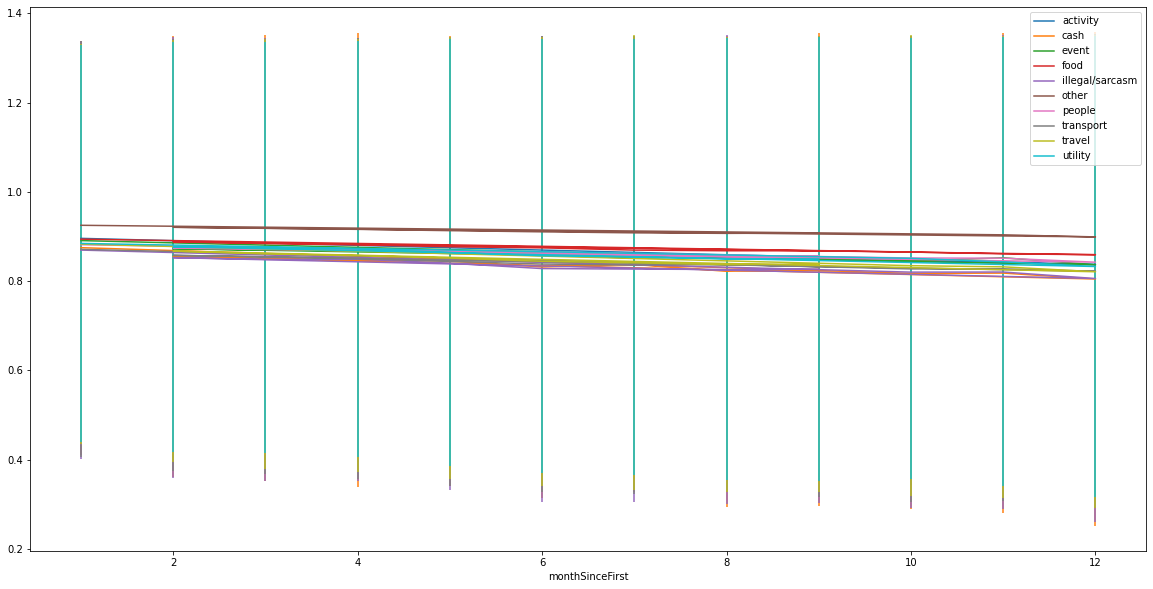

In [35]:
fig, ax = plt.subplots(figsize=(20, 10))

for key, group in pdToPlot.groupby('class'):
    group.plot('monthSinceFirst', 'avgSpendShare', yerr='stdev_2', label=key, ax=ax) 

plt.show()